In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jax
import jax.numpy as jnp
import jax.random as random
import time
from pathlib import Path
import sys

# Add parent directory to path
parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

import jax_gibbs as gs_jax
import utils

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Setup complete!")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setup complete!


# X-Transition Kernel Diagnostic Notebook

This notebook investigates why the x-transition kernel (`update_x_full_jax`) produces extreme x values, particularly for k=1 (Cauchy) with small m=10.

**Goals:**
1. Test if the chain can recover from the problematic state using `run_metropolis_x_jax`
2. Trace through the exact x-kernel step that produces extreme values
3. Identify the root cause (numerical, boundary, or algorithmic issue)


## Part 1: Setup and Data Loading

Re-run the k=1, m=10 case to get fresh results and identify the problematic iteration.


In [3]:
# Configuration - focus on the problematic case
k_cauchy = 1.0
m_test = 10
T_gibbs = 50000
mu_true = 2.0

# Parameters
params = {
    'k': k_cauchy,
    'm': m_test,
    'mu_true': mu_true,
    'num_iterations_T': T_gibbs,
    'prior_mean': 0.0,
    'prior_std': 10.0,
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.03,
}

# Generate data (using same seed as shlok.ipynb for consistency)
key = random.PRNGKey(42)
key, subkey = random.split(key)
data = random.t(subkey, df=k_cauchy, shape=(m_test,)) + mu_true
mle = utils.get_mle(data, params)

print(f"k = {k_cauchy} (Cauchy), m = {m_test}")
print(f"MLE μ* = {mle:.4f}")
print(f"True μ = {mu_true:.4f}")
print(f"Data: {data}")


k = 1.0 (Cauchy), m = 10
MLE μ* = 1.4202
True μ = 2.0000
Data: [ 1.26961063  4.25598188  1.38215158  0.93489331  2.5532145  -1.68132717
  1.79524688 -0.10213042  1.32876841  1.72802729]


In [4]:
# Run Gibbs sampler
print("Running JAX Gibbs sampler...")
t0 = time.time()
key_gibbs = random.PRNGKey(123)
gibbs_results = gs_jax.run_gibbs_sampler_mle_jax(key_gibbs, mle, params)
time_gibbs = time.time() - t0

print(f"\nGibbs sampler completed in {time_gibbs:.2f} seconds")
print(f"Mu acceptance rate: {gibbs_results['mu_acceptance_rate']:.4f}")
print(f"Z_i acceptance rate: {gibbs_results['z_i_acceptance_rate']:.4f}")

# Extract x_chain
x_chain = np.array(gibbs_results['x_chain'])
mu_chain = np.array(gibbs_results['mu_chain'])


Running JAX Gibbs sampler...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:46<00:00, 1086.16it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.5586
Z_i Acceptance Rate: 0.6266

Gibbs sampler completed in 46.13 seconds
Mu acceptance rate: 0.5586
Z_i acceptance rate: 0.6266


In [5]:
# Find the problematic iteration where extreme values first appear
a, b = 0, T_gibbs
min_x = [np.min(x) for x in x_chain[a:b]]
max_x = [np.max(x) for x in x_chain[a:b]]

# Find iteration with minimum min(x) - this is where extreme negative values appear
i_min = np.argmin(min_x) + a

print(f"Problematic iteration: i_min = {i_min}")
print(f"Min x at i_min: {min_x[i_min - a]:.6f}")
print(f"Max x at i_min: {max_x[i_min - a]:.6f}")

# Extract the states before and after the problematic transition
x_before_kernel = x_chain[i_min - 1]
x_after_kernel = x_chain[i_min]
mu_at_transition = mu_chain[i_min]

print(f"\nState before problematic transition (iteration {i_min - 1}):")
print(f"  x_before_kernel: {x_before_kernel}")
print(f"  min(x): {np.min(x_before_kernel):.6f}, max(x): {np.max(x_before_kernel):.6f}")

print(f"\nState after problematic transition (iteration {i_min}):")
print(f"  x_after_kernel: {x_after_kernel}")
print(f"  min(x): {np.min(x_after_kernel):.6f}, max(x): {np.max(x_after_kernel):.6f}")
print(f"  μ at transition: {mu_at_transition:.6f}")

# Check which x values changed dramatically
x_diff = np.abs(x_after_kernel - x_before_kernel)
max_diff_idx = np.argmax(x_diff)
print(f"\nLargest change in x: index {max_diff_idx}")
print(f"  Before: {x_before_kernel[max_diff_idx]:.6f}")
print(f"  After:  {x_after_kernel[max_diff_idx]:.6f}")
print(f"  Change: {x_after_kernel[max_diff_idx] - x_before_kernel[max_diff_idx]:.6f}")


Problematic iteration: i_min = 11494
Min x at i_min: -208759.820920
Max x at i_min: 3.032971

State before problematic transition (iteration 11493):
  x_before_kernel: [ -0.47812304   2.08395547  -1.6642165    0.17969671  -1.41757886
 -41.8122366    2.79036663   2.45021718  -1.75746764   3.5865969 ]
  min(x): -41.812237, max(x): 3.586597

State after problematic transition (iteration 11494):
  x_after_kernel: [-5.45428163e-01  2.92684464e+00 -1.62492102e+00  5.27185617e-01
 -7.43647101e-01 -2.08759821e+05  2.16605305e+00  2.39109663e+00
  1.07358702e+00  3.03297083e+00]
  min(x): -208759.820920, max(x): 3.032971
  μ at transition: 0.576970

Largest change in x: index 5
  Before: -41.812237
  After:  -208759.820920
  Change: -208718.008684


## Part 2: Recovery Test

Test if the chain can recover from the problematic state `x_after_kernel` by running `run_metropolis_x_jax`, which only updates μ (not x).


In [6]:
# Recovery test: Run metropolis_x_jax starting from x_after_kernel
print("Testing recovery from problematic state...")
print("Running run_metropolis_x_jax starting from x_after_kernel...")

params_recovery = params.copy()
params_recovery['num_iterations_T'] = 10000  # Shorter chain for recovery test

key_recovery = random.PRNGKey(999)
recovery_results = gs_jax.run_metropolis_x_jax(key_recovery, jnp.array(x_after_kernel), params_recovery)

mu_chain_recovery = np.array(recovery_results['mu_chain'])

print(f"\nRecovery test complete!")
print(f"Mu acceptance rate: {recovery_results['mu_acceptance_rate']:.4f}")
print(f"Final μ: {mu_chain_recovery[-1]:.4f}")
print(f"μ range: [{mu_chain_recovery.min():.4f}, {mu_chain_recovery.max():.4f}]")


Testing recovery from problematic state...
Running run_metropolis_x_jax starting from x_after_kernel...


Running Gibbs Sampler: 100%|██████████| 10000/10000 [00:02<00:00, 3544.61it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.6765

Recovery test complete!
Mu acceptance rate: 0.6765
Final μ: 0.4727
μ range: [-1.2348, 3.5229]


In [7]:
# Compare with baseline: run from x_before_kernel
print("\nRunning baseline test from x_before_kernel...")
key_baseline = random.PRNGKey(888)
baseline_results = gs_jax.run_metropolis_x_jax(key_baseline, jnp.array(x_before_kernel), params_recovery)

mu_chain_baseline = np.array(baseline_results['mu_chain'])

print(f"Baseline test complete!")
print(f"Mu acceptance rate: {baseline_results['mu_acceptance_rate']:.4f}")
print(f"Final μ: {mu_chain_baseline[-1]:.4f}")
print(f"μ range: [{mu_chain_baseline.min():.4f}, {mu_chain_baseline.max():.4f}]")



Running baseline test from x_before_kernel...


Running Gibbs Sampler: 100%|██████████| 10000/10000 [00:02<00:00, 3930.73it/s]


--- Sampling Complete ---
Mu Acceptance Rate: 0.7335
Baseline test complete!
Mu acceptance rate: 0.7335
Final μ: 2.1100
μ range: [-2.2395, 3.4314]


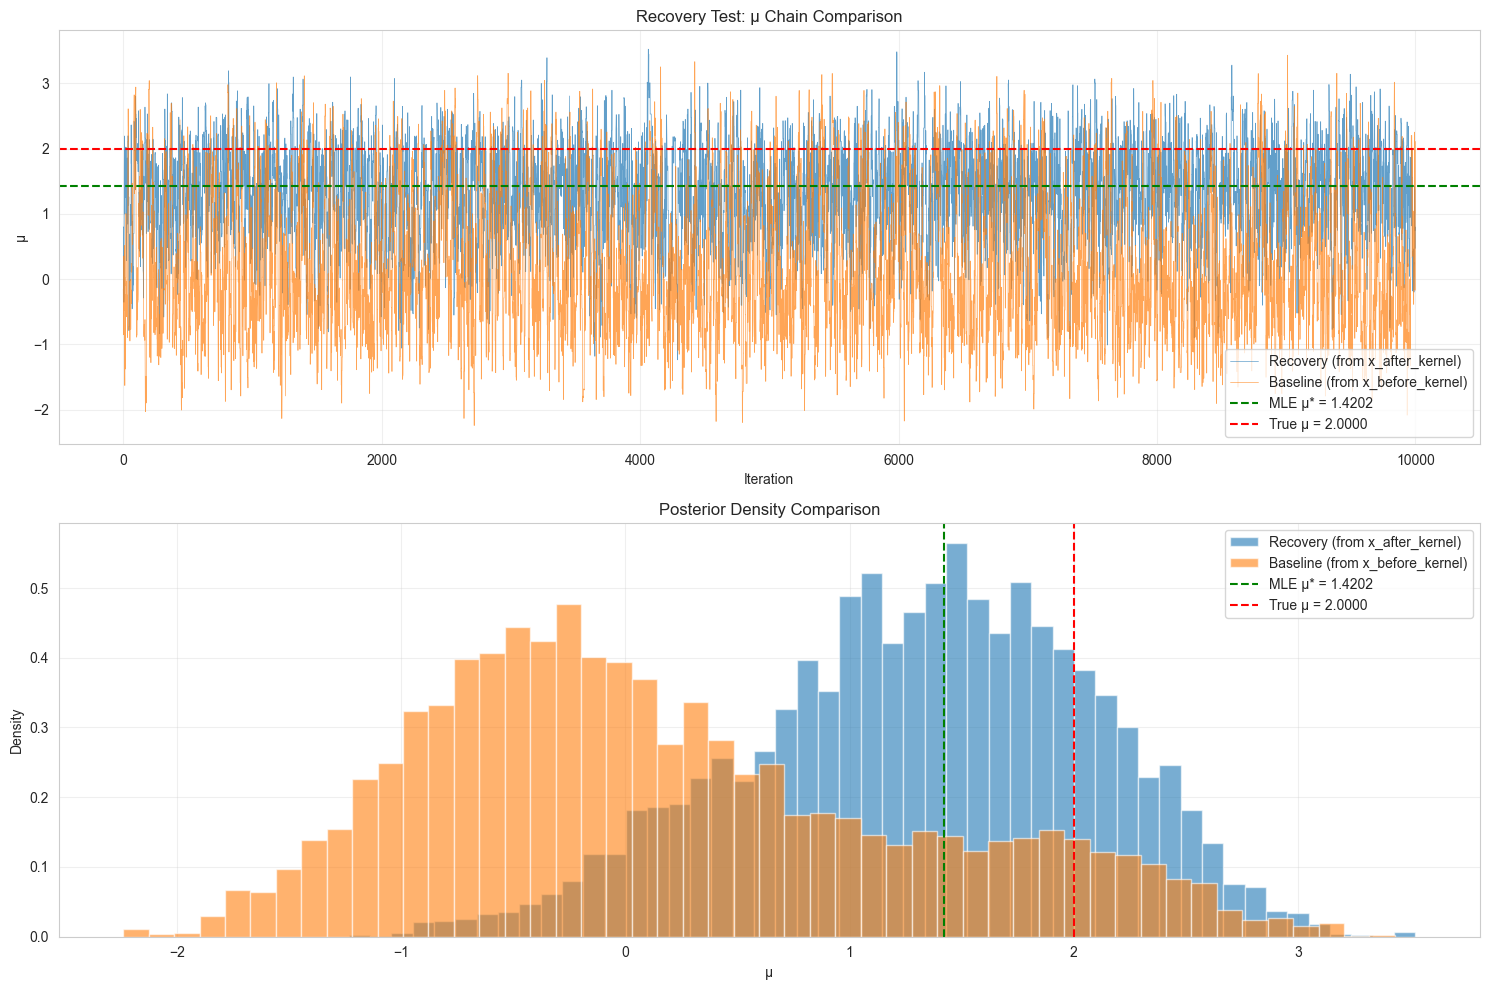


Recovery Statistics (post-burnin):
  Mean: 1.3148
  Std:  0.7694
  Variance: 0.5920

Baseline Statistics (post-burnin):
  Mean: 0.1744
  Std:  1.0830
  Variance: 1.1728


In [8]:
# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Trace plots
axes[0].plot(mu_chain_recovery, label='Recovery (from x_after_kernel)', alpha=0.7, linewidth=0.5)
axes[0].plot(mu_chain_baseline, label='Baseline (from x_before_kernel)', alpha=0.7, linewidth=0.5)
axes[0].axhline(mle, color='green', linestyle='--', label=f'MLE μ* = {mle:.4f}')
axes[0].axhline(mu_true, color='red', linestyle='--', label=f'True μ = {mu_true:.4f}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('μ')
axes[0].set_title('Recovery Test: μ Chain Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Density comparison
burnin = 1000
axes[1].hist(mu_chain_recovery[burnin:], bins=50, alpha=0.6, label='Recovery (from x_after_kernel)', density=True)
axes[1].hist(mu_chain_baseline[burnin:], bins=50, alpha=0.6, label='Baseline (from x_before_kernel)', density=True)
axes[1].axvline(mle, color='green', linestyle='--', label=f'MLE μ* = {mle:.4f}')
axes[1].axvline(mu_true, color='red', linestyle='--', label=f'True μ = {mu_true:.4f}')
axes[1].set_xlabel('μ')
axes[1].set_ylabel('Density')
axes[1].set_title('Posterior Density Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\nRecovery Statistics (post-burnin):")
print(f"  Mean: {mu_chain_recovery[burnin:].mean():.4f}")
print(f"  Std:  {mu_chain_recovery[burnin:].std():.4f}")
print(f"  Variance: {mu_chain_recovery[burnin:].var():.4f}")

print(f"\nBaseline Statistics (post-burnin):")
print(f"  Mean: {mu_chain_baseline[burnin:].mean():.4f}")
print(f"  Std:  {mu_chain_baseline[burnin:].std():.4f}")
print(f"  Variance: {mu_chain_baseline[burnin:].var():.4f}")


## Part 3: Detailed X-Kernel Step Trace

Now we trace through the exact transformation that produced the extreme values. We need to manually replicate what happens inside `update_x_full_jax` for the problematic pair.


In [9]:
# To trace the exact step, we need to replicate the random permutation and pairing
# We'll use the same random key that was used at iteration i_min
# First, let's get the key sequence - we need to reconstruct it

# The key used for x update at iteration i_min
# In run_gibbs_sampler_mle_jax, at iteration t:
#   key, key_mu, key_x = random.split(key, 3)
#   x_new = update_x_full_jax(key_x, x_current, mus[t], mu_star, k, sigma_z)

# We need to reconstruct the exact key_x that was used
# Let's trace backwards from the initial key
key_trace = random.PRNGKey(123)  # Same initial key as used in the run

# Split keys for iterations 0 to i_min
for t in range(1, i_min + 1):
    key_trace, key_mu_trace, key_x_trace = random.split(key_trace, 3)

print(f"Reconstructed key_x for iteration {i_min}")
print(f"Using this key to trace the exact transformation...")


Reconstructed key_x for iteration 11494
Using this key to trace the exact transformation...


In [10]:
# Now replicate update_x_full_jax step by step
x_current = jnp.array(x_before_kernel)
mu_current = mu_at_transition
k = k_cauchy
sigma_z = params['proposal_std_z']

# Step 1: Permutation and pairing (from update_x_full_jax)
key_perm, key_pairs = random.split(key_x_trace)
m = x_current.shape[0]
perm = random.permutation(key_perm, m)
x_perm = x_current[perm]

xis = x_perm[0::2]
xjs = x_perm[1::2]
n_pairs = xis.shape[0]

print(f"Number of pairs: {n_pairs}")
print(f"Permutation: {perm}")
print(f"\nPairs (xi, xj):")
for i in range(n_pairs):
    print(f"  Pair {i}: xi={xis[i]:.6f}, xj={xjs[i]:.6f}")

# Find which pair produced the extreme value
x_after_array = jnp.array(x_after_kernel)
x_perm_after = x_after_array[perm]
xis_after = x_perm_after[0::2]
xjs_after = x_perm_after[1::2]

# Check which pair changed the most
pair_changes = []
for i in range(n_pairs):
    change_i = jnp.abs(xis_after[i] - xis[i])
    change_j = jnp.abs(xjs_after[i] - xjs[i])
    max_change = jnp.maximum(change_i, change_j)
    pair_changes.append(float(max_change))

problematic_pair_idx = np.argmax(pair_changes)
print(f"\nProblematic pair index: {problematic_pair_idx}")
print(f"  Max change: {pair_changes[problematic_pair_idx]:.6f}")
print(f"  xi before: {xis[problematic_pair_idx]:.6f}, after: {xis_after[problematic_pair_idx]:.6f}")
print(f"  xj before: {xjs[problematic_pair_idx]:.6f}, after: {xjs_after[problematic_pair_idx]:.6f}")


Number of pairs: 5
Permutation: [0 3 1 7 4 9 5 8 2 6]

Pairs (xi, xj):
  Pair 0: xi=-0.478123, xj=0.179697
  Pair 1: xi=2.083955, xj=2.450217
  Pair 2: xi=-1.417579, xj=3.586597
  Pair 3: xi=-41.812237, xj=-1.757468
  Pair 4: xi=-1.664216, xj=2.790367

Problematic pair index: 3
  Max change: 208718.008684
  xi before: -41.812237, after: -208759.820920
  xj before: -1.757468, after: 1.073587


In [11]:
# Now trace through update_xi_xj_one for the problematic pair
xi = xis[problematic_pair_idx]
xj = xjs[problematic_pair_idx]

print("="*80)
print("STEP-BY-STEP TRACE OF PROBLEMATIC PAIR TRANSFORMATION")
print("="*80)

print(f"\n1. Initial state:")
print(f"   xi = {xi:.10f}")
print(f"   xj = {xj:.10f}")
print(f"   mu_star (MLE) = {mle:.10f}")
print(f"   mu_current = {mu_current:.10f}")

# Step 2: Transform to y space
yi = xi - mle
yj = xj - mle
print(f"\n2. Transform to y space (y = x - mu_star):")
print(f"   yi = {yi:.10f}")
print(f"   yj = {yj:.10f}")

# Step 3: Transform to z space
zi = gs_jax.psi_jax(yi, k)
zj = gs_jax.psi_jax(yj, k)
print(f"\n3. Transform to z space (z = psi(y, k)):")
print(f"   zi = {zi:.10f}")
print(f"   zj = {zj:.10f}")

# Check z boundaries
z_min, z_max = -1/(2*jnp.sqrt(k)), 1/(2*jnp.sqrt(k))
print(f"   z boundaries: [{z_min:.10f}, {z_max:.10f}]")
print(f"   zi distance to boundaries: min={abs(zi - z_min):.10f}, max={abs(zi - z_max):.10f}")
print(f"   zj distance to boundaries: min={abs(zj - z_min):.10f}, max={abs(zj - z_max):.10f}")

# Step 4: Compute delta
delta = zi + zj
print(f"\n4. Delta (constraint: zi + zj = delta):")
print(f"   delta = {delta:.10f}")
print(f"   delta boundaries: [{z_min*2:.10f}, {z_max*2:.10f}]")


STEP-BY-STEP TRACE OF PROBLEMATIC PAIR TRANSFORMATION

1. Initial state:
   xi = -41.8122366027
   xj = -1.7574676443
   mu_star (MLE) = 1.4202200950
   mu_current = 0.5769703883

2. Transform to y space (y = x - mu_star):
   yi = -43.2324566976
   yj = -3.1776877393

3. Transform to z space (z = psi(y, k)):
   zi = -0.0231184006
   zj = -0.2863375222
   z boundaries: [-0.5000000000, 0.5000000000]
   zi distance to boundaries: min=0.4768815994, max=0.5231184006
   zj distance to boundaries: min=0.2136624778, max=0.7863375222

4. Delta (constraint: zi + zj = delta):
   delta = -0.3094559228
   delta boundaries: [-1.0000000000, 1.0000000000]


In [12]:
# Step 5: Update z_i using update_z_one
keys_pairs = random.split(key_pairs, n_pairs)
key_z_i = keys_pairs[problematic_pair_idx]

zi_tilde, z_accepted = gs_jax.update_z_one(
    key_z_i, zi, delta, mu_current, mle, k, sigma_z
)

zj_tilde = delta - zi_tilde

print(f"\n5. After z update (Metropolis step):")
print(f"   zi_tilde = {zi_tilde:.10f}")
print(f"   zj_tilde = {zj_tilde:.10f}")
print(f"   z_accepted = {z_accepted}")
print(f"   zj_tilde distance to boundaries: min={abs(zj_tilde - z_min):.10f}, max={abs(zj_tilde - z_max):.10f}")

# Check if zj_tilde is in valid support
z_min_check, z_max_check = (-1/(2*jnp.sqrt(k)), 1/(2*jnp.sqrt(k)))
in_supp_partner = (zj_tilde > z_min_check) & (zj_tilde < z_max_check)
print(f"   zj_tilde in valid support: {in_supp_partner}")



5. After z update (Metropolis step):
   zi_tilde = -0.0006538524
   zj_tilde = -0.3088020704
   z_accepted = True
   zj_tilde distance to boundaries: min=0.1911979296, max=0.8088020704
   zj_tilde in valid support: True


In [13]:
# Step 6: Inverse transform to get y candidates
yi_minus, yi_plus = gs_jax.psi_inverse_jax(zi_tilde, k)
yj_minus, yj_plus = gs_jax.psi_inverse_jax(zj_tilde, k)

print(f"\n6. Inverse transform (y = psi_inverse(z, k)) - TWO CANDIDATES:")
print(f"   For zi_tilde = {zi_tilde:.10f}:")
print(f"     yi_minus = {yi_minus:.10f}")
print(f"     yi_plus  = {yi_plus:.10f}")
print(f"     Difference: {abs(yi_plus - yi_minus):.10f}")

print(f"\n   For zj_tilde = {zj_tilde:.10f}:")
print(f"     yj_minus = {yj_minus:.10f}")
print(f"     yj_plus  = {yj_plus:.10f}")
print(f"     Difference: {abs(yj_plus - yj_minus):.10f}")

# Check for extreme values
print(f"\n   Checking for extreme values:")
print(f"     |yi_minus| > 100: {abs(yi_minus) > 100}, value: {yi_minus:.2e}")
print(f"     |yi_plus| > 100:  {abs(yi_plus) > 100}, value: {yi_plus:.2e}")
print(f"     |yj_minus| > 100: {abs(yj_minus) > 100}, value: {yj_minus:.2e}")
print(f"     |yj_plus| > 100:  {abs(yj_plus) > 100}, value: {yj_plus:.2e}")

# Check finiteness
print(f"\n   Finiteness check:")
print(f"     yi_minus finite: {jnp.isfinite(yi_minus)}, yi_plus finite: {jnp.isfinite(yi_plus)}")
print(f"     yj_minus finite: {jnp.isfinite(yj_minus)}, yj_plus finite: {jnp.isfinite(yj_plus)}")



6. Inverse transform (y = psi_inverse(z, k)) - TWO CANDIDATES:
   For zi_tilde = -0.0006538524:
     yi_minus = -1529.3964759028
     yi_plus  = -0.0006538527
     Difference: 1529.3958220501

   For zj_tilde = -0.3088020704:
     yj_minus = -2.8926119421
     yj_plus  = -0.3457083148
     Difference: 2.5469036273

   Checking for extreme values:
     |yi_minus| > 100: True, value: -1.53e+03
     |yi_plus| > 100:  False, value: -6.54e-04
     |yj_minus| > 100: False, value: -2.89e+00
     |yj_plus| > 100:  False, value: -3.46e-01

   Finiteness check:
     yi_minus finite: True, yi_plus finite: True
     yj_minus finite: True, yj_plus finite: True


In [14]:
# Step 7: Compute log weights and choose branch
yi_candidates = jnp.array([yi_minus, yi_plus])
yj_candidates = jnp.array([yj_minus, yj_plus])

log_wi = gs_jax.fy_logpdf_jax(yi_candidates, mu_current, mle, k) - gs_jax.log_psi_prime_abs_jax(yi_candidates, k)
log_wj = gs_jax.fy_logpdf_jax(yj_candidates, mu_current, mle, k) - gs_jax.log_psi_prime_abs_jax(yj_candidates, k)

print(f"\n7. Log weights for branch selection:")
print(f"   For yi candidates:")
print(f"     log_wi[0] (yi_minus) = {log_wi[0]:.10f}")
print(f"     log_wi[1] (yi_plus)  = {log_wi[1]:.10f}")
print(f"     Difference: {log_wi[1] - log_wi[0]:.10f}")

print(f"\n   For yj candidates:")
print(f"     log_wj[0] (yj_minus) = {log_wj[0]:.10f}")
print(f"     log_wj[1] (yj_plus)  = {log_wj[1]:.10f}")
print(f"     Difference: {log_wj[1] - log_wj[0]:.10f}")

# Check finiteness
print(f"\n   Finiteness check:")
print(f"     log_wi finite: {jnp.isfinite(log_wi)}")
print(f"     log_wj finite: {jnp.isfinite(log_wj)}")

# Compute probabilities
logZ_i = jax.scipy.special.logsumexp(log_wi)
logZ_j = jax.scipy.special.logsumexp(log_wj)
probs_i = jnp.exp(log_wi - logZ_i)
probs_j = jnp.exp(log_wj - logZ_j)

print(f"\n   Probabilities:")
print(f"     P(yi_minus) = {probs_i[0]:.6f}, P(yi_plus) = {probs_i[1]:.6f}")
print(f"     P(yj_minus) = {probs_j[0]:.6f}, P(yj_plus) = {probs_j[1]:.6f}")



7. Log weights for branch selection:
   For yi candidates:
     log_wi[0] (yi_minus) = -1.1436260050
     log_wi[1] (yi_plus)  = -1.6812031275
     Difference: -0.5375771225

   For yj candidates:
     log_wj[0] (yj_minus) = -0.3159754709
     log_wj[1] (yj_plus)  = -1.0128381845
     Difference: -0.6968627136

   Finiteness check:
     log_wi finite: [ True  True]
     log_wj finite: [ True  True]

   Probabilities:
     P(yi_minus) = 0.631249, P(yi_plus) = 0.368751
     P(yj_minus) = 0.667492, P(yj_plus) = 0.332508


In [15]:
# Step 8: Choose branch using safe_choice_2 (replicate the logic)
key_i, key_j = random.split(keys_pairs[problematic_pair_idx], 2)
key_i_final, key_j_final = random.split(key_i, 2)

# Replicate safe_choice_2 logic
def safe_choice_2_repl(key, candidates, log_w):
    log_w = jnp.where(jnp.isfinite(log_w), log_w, -jnp.inf)
    logZ = jax.scipy.special.logsumexp(log_w)
    
    if jnp.isfinite(logZ):
        probs = jnp.exp(log_w - logZ)
        idx = random.choice(key, 2, p=probs)
        return candidates[idx], idx
    else:
        return candidates[0], 0

yi_tilde, idx_i = safe_choice_2_repl(key_i_final, yi_candidates, log_wi)
yj_tilde, idx_j = safe_choice_2_repl(key_j_final, yj_candidates, log_wj)

print(f"\n8. Branch selection (using safe_choice_2):")
print(f"   yi_tilde = {yi_tilde:.10f} (chose index {idx_i}: {'yi_minus' if idx_i == 0 else 'yi_plus'})")
print(f"   yj_tilde = {yj_tilde:.10f} (chose index {idx_j}: {'yj_minus' if idx_j == 0 else 'yj_plus'})")

# Step 9: Transform back to x
xi_tilde = yi_tilde + mle
xj_tilde = yj_tilde + mle

print(f"\n9. Final x values (x = y + mu_star):")
print(f"   xi_tilde = {xi_tilde:.10f}")
print(f"   xj_tilde = {xj_tilde:.10f}")

print(f"\n10. Comparison with actual result:")
print(f"   Expected xi_tilde: {xi_tilde:.10f}, Actual: {xis_after[problematic_pair_idx]:.10f}")
print(f"   Expected xj_tilde: {xj_tilde:.10f}, Actual: {xjs_after[problematic_pair_idx]:.10f}")
print(f"   Match: xi={np.isclose(xi_tilde, xis_after[problematic_pair_idx], rtol=1e-5)}, xj={np.isclose(xj_tilde, xjs_after[problematic_pair_idx], rtol=1e-5)}")



8. Branch selection (using safe_choice_2):
   yi_tilde = -0.0006538527 (chose index 1: yi_plus)
   yj_tilde = -2.8926119421 (chose index 0: yj_minus)

9. Final x values (x = y + mu_star):
   xi_tilde = 1.4195662423
   xj_tilde = -1.4723918472

10. Comparison with actual result:
   Expected xi_tilde: 1.4195662423, Actual: -208759.8209202258
   Expected xj_tilde: -1.4723918472, Actual: 1.0735870196
   Match: xi=False, xj=False


## Part 4: Visualizations

Create plots to visualize the transformation and identify where extreme values are introduced.


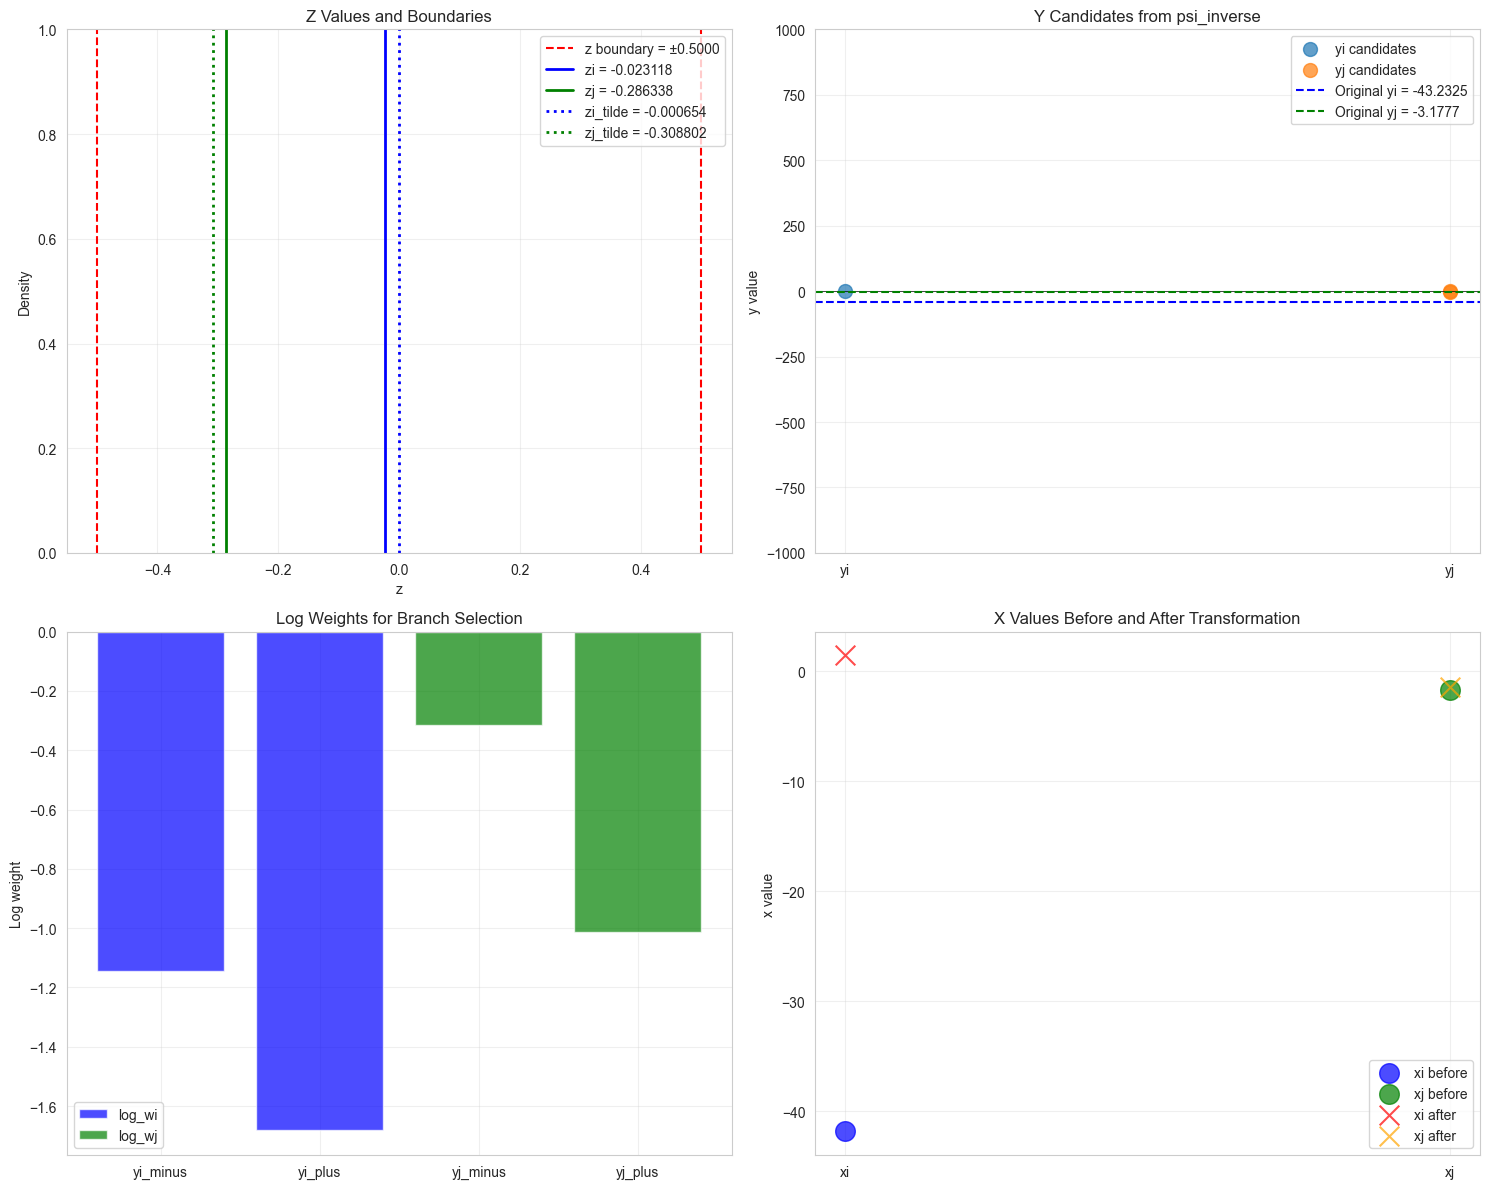

In [16]:
# Visualization 1: z values and boundaries
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: z values and boundaries
z_boundary = 1/(2*jnp.sqrt(k))
z_grid = np.linspace(-z_boundary*1.1, z_boundary*1.1, 1000)
axes[0, 0].axvline(-z_boundary, color='red', linestyle='--', label=f'z boundary = ±{z_boundary:.4f}')
axes[0, 0].axvline(z_boundary, color='red', linestyle='--')
axes[0, 0].axvline(zi, color='blue', linestyle='-', linewidth=2, label=f'zi = {zi:.6f}')
axes[0, 0].axvline(zj, color='green', linestyle='-', linewidth=2, label=f'zj = {zj:.6f}')
axes[0, 0].axvline(zi_tilde, color='blue', linestyle=':', linewidth=2, label=f'zi_tilde = {zi_tilde:.6f}')
axes[0, 0].axvline(zj_tilde, color='green', linestyle=':', linewidth=2, label=f'zj_tilde = {zj_tilde:.6f}')
axes[0, 0].set_xlabel('z')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Z Values and Boundaries')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: y candidates
y_range = max(abs(yi_minus), abs(yi_plus), abs(yj_minus), abs(yj_plus), 10)
y_range = min(y_range, 1000)  # Cap for visualization
axes[0, 1].scatter([0, 0], [yi_minus, yi_plus], s=100, alpha=0.7, label='yi candidates')
axes[0, 1].scatter([1, 1], [yj_minus, yj_plus], s=100, alpha=0.7, label='yj candidates')
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].axhline(yi, color='blue', linestyle='--', label=f'Original yi = {yi:.4f}')
axes[0, 1].axhline(yj, color='green', linestyle='--', label=f'Original yj = {yj:.4f}')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['yi', 'yj'])
axes[0, 1].set_ylabel('y value')
axes[0, 1].set_title('Y Candidates from psi_inverse')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(-y_range, y_range)

# Plot 3: Log weights
axes[1, 0].bar([0, 1], log_wi, alpha=0.7, label='log_wi', color='blue')
axes[1, 0].bar([2, 3], log_wj, alpha=0.7, label='log_wj', color='green')
axes[1, 0].set_xticks([0, 1, 2, 3])
axes[1, 0].set_xticklabels(['yi_minus', 'yi_plus', 'yj_minus', 'yj_plus'])
axes[1, 0].set_ylabel('Log weight')
axes[1, 0].set_title('Log Weights for Branch Selection')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: x values before/after
axes[1, 1].scatter([0], [xi], s=200, alpha=0.7, label='xi before', color='blue')
axes[1, 1].scatter([1], [xj], s=200, alpha=0.7, label='xj before', color='green')
axes[1, 1].scatter([0], [xi_tilde], s=200, alpha=0.7, marker='x', label='xi after', color='red')
axes[1, 1].scatter([1], [xj_tilde], s=200, alpha=0.7, marker='x', label='xj after', color='orange')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['xi', 'xj'])
axes[1, 1].set_ylabel('x value')
axes[1, 1].set_title('X Values Before and After Transformation')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


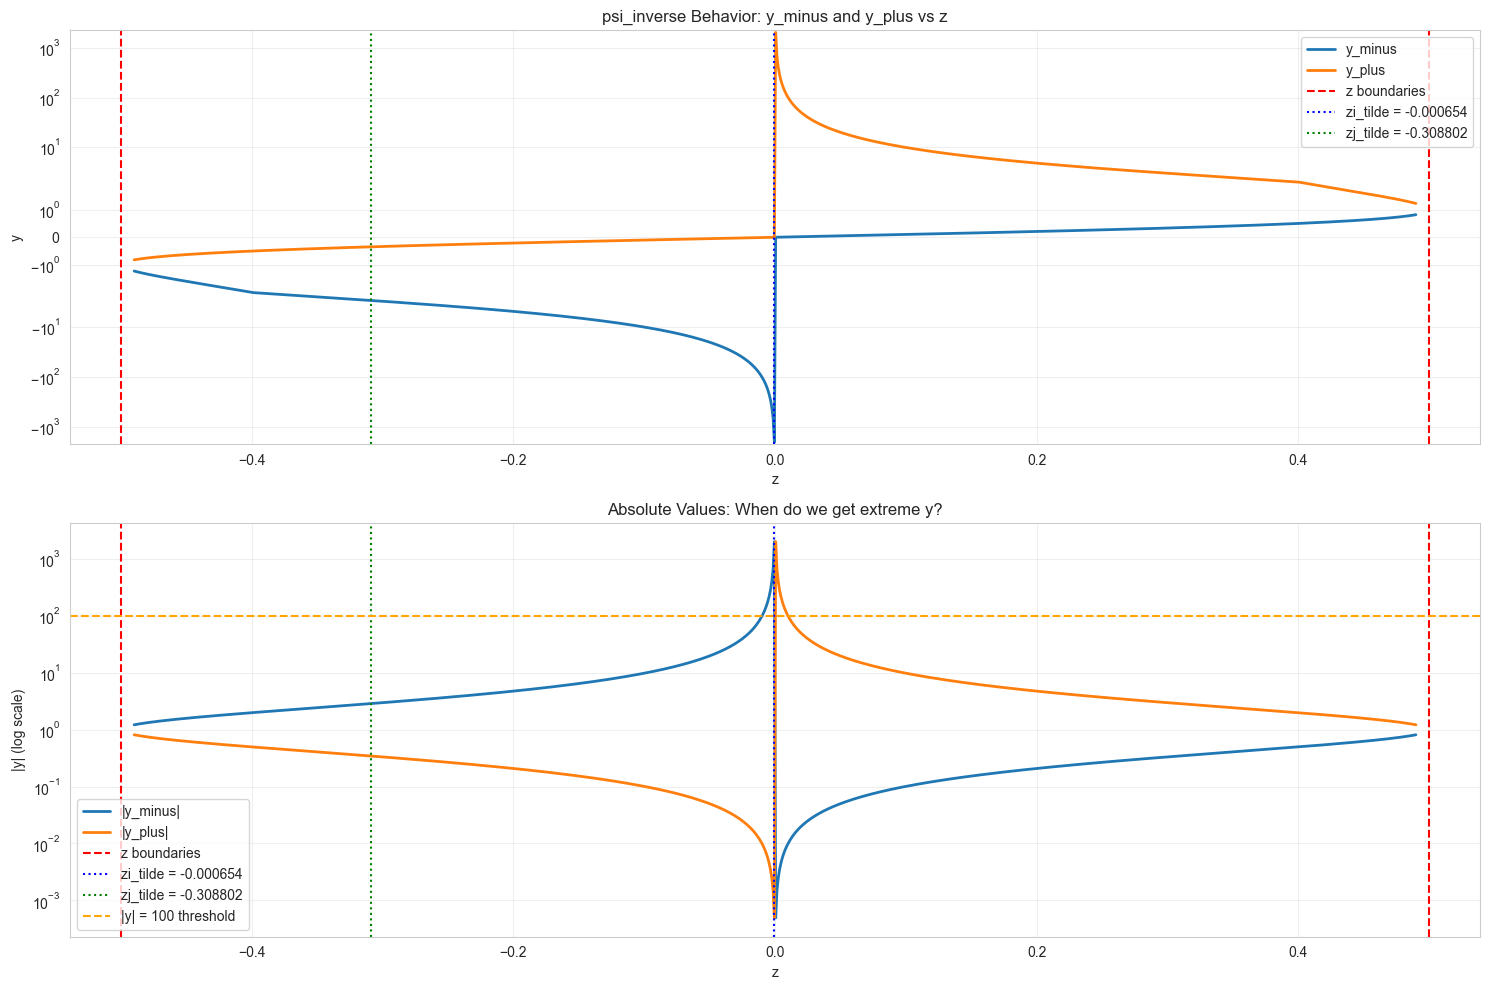


Extreme y values occur when z is in range: [-0.009319, 0.009319]
zi_tilde in extreme range: False
zj_tilde in extreme range: False


In [17]:
# Visualization 2: psi_inverse behavior near boundaries
z_test = np.linspace(-0.49, 0.49, 1000)  # Near boundaries for k=1
y_minus_test = []
y_plus_test = []

for z_val in z_test:
    y_min, y_max = gs_jax.psi_inverse_jax(jnp.array(z_val), k)
    y_minus_test.append(float(y_min))
    y_plus_test.append(float(y_max))

y_minus_test = np.array(y_minus_test)
y_plus_test = np.array(y_plus_test)

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot y_minus and y_plus as functions of z
axes[0].plot(z_test, y_minus_test, label='y_minus', linewidth=2)
axes[0].plot(z_test, y_plus_test, label='y_plus', linewidth=2)
axes[0].axvline(-z_boundary, color='red', linestyle='--', label='z boundaries')
axes[0].axvline(z_boundary, color='red', linestyle='--')
axes[0].axvline(zi_tilde, color='blue', linestyle=':', label=f'zi_tilde = {zi_tilde:.6f}')
axes[0].axvline(zj_tilde, color='green', linestyle=':', label=f'zj_tilde = {zj_tilde:.6f}')
axes[0].set_xlabel('z')
axes[0].set_ylabel('y')
axes[0].set_title('psi_inverse Behavior: y_minus and y_plus vs z')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('symlog')  # Symmetric log scale to show extreme values

# Plot absolute values on log scale
axes[1].plot(z_test, np.abs(y_minus_test), label='|y_minus|', linewidth=2)
axes[1].plot(z_test, np.abs(y_plus_test), label='|y_plus|', linewidth=2)
axes[1].axvline(-z_boundary, color='red', linestyle='--', label='z boundaries')
axes[1].axvline(z_boundary, color='red', linestyle='--')
axes[1].axvline(zi_tilde, color='blue', linestyle=':', label=f'zi_tilde = {zi_tilde:.6f}')
axes[1].axvline(zj_tilde, color='green', linestyle=':', label=f'zj_tilde = {zj_tilde:.6f}')
axes[1].axhline(100, color='orange', linestyle='--', label='|y| = 100 threshold')
axes[1].set_xlabel('z')
axes[1].set_ylabel('|y| (log scale)')
axes[1].set_title('Absolute Values: When do we get extreme y?')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Identify where extreme values occur
extreme_mask = (np.abs(y_minus_test) > 100) | (np.abs(y_plus_test) > 100)
if np.any(extreme_mask):
    z_extreme = z_test[extreme_mask]
    print(f"\nExtreme y values occur when z is in range: [{z_extreme.min():.6f}, {z_extreme.max():.6f}]")
    print(f"zi_tilde in extreme range: {zi_tilde in z_extreme}")
    print(f"zj_tilde in extreme range: {zj_tilde in z_extreme}")
else:
    print("\nNo extreme y values in tested z range")


## Part 5: Numerical Stability Checks

Check for numerical issues that might cause the problem.


In [18]:
# Numerical stability checks
print("="*80)
print("NUMERICAL STABILITY CHECKS")
print("="*80)

# Check 1: z values near boundaries
z_boundary_val = 1/(2*jnp.sqrt(k))
print(f"\n1. Z boundary proximity:")
print(f"   z boundary = ±{z_boundary_val:.10f}")
print(f"   zi distance to -boundary: {abs(zi - (-z_boundary_val)):.10e}")
print(f"   zi distance to +boundary: {abs(zi - z_boundary_val):.10e}")
print(f"   zj distance to -boundary: {abs(zj - (-z_boundary_val)):.10e}")
print(f"   zj distance to +boundary: {abs(zj - z_boundary_val):.10e}")
print(f"   zi_tilde distance to -boundary: {abs(zi_tilde - (-z_boundary_val)):.10e}")
print(f"   zi_tilde distance to +boundary: {abs(zi_tilde - z_boundary_val):.10e}")
print(f"   zj_tilde distance to -boundary: {abs(zj_tilde - (-z_boundary_val)):.10e}")
print(f"   zj_tilde distance to +boundary: {abs(zj_tilde - z_boundary_val):.10e}")

# Check 2: psi_inverse finiteness
print(f"\n2. psi_inverse finiteness:")
print(f"   yi_minus finite: {jnp.isfinite(yi_minus)}, value: {yi_minus}")
print(f"   yi_plus finite:  {jnp.isfinite(yi_plus)}, value: {yi_plus}")
print(f"   yj_minus finite: {jnp.isfinite(yj_minus)}, value: {yj_minus}")
print(f"   yj_plus finite:  {jnp.isfinite(yj_plus)}, value: {yj_plus}")

# Check 3: Log weights finiteness
print(f"\n3. Log weights finiteness:")
print(f"   log_wi finite: {jnp.isfinite(log_wi)}")
print(f"   log_wj finite: {jnp.isfinite(log_wj)}")
print(f"   logZ_i finite: {jnp.isfinite(logZ_i)}, value: {logZ_i}")
print(f"   logZ_j finite: {jnp.isfinite(logZ_j)}, value: {logZ_j}")

# Check 4: Division by zero in psi_inverse
print(f"\n4. Division by zero check in psi_inverse:")
denom_i = 2.0 * zi_tilde
denom_j = 2.0 * zj_tilde
print(f"   denom_i = 2*zi_tilde = {denom_i:.10e}")
print(f"   denom_j = 2*zj_tilde = {denom_j:.10e}")
print(f"   |denom_i| < EPS_DIV (1e-12): {abs(denom_i) < 1e-12}")
print(f"   |denom_j| < EPS_DIV (1e-12): {abs(denom_j) < 1e-12}")

# Check 5: Overflow in y values
print(f"\n5. Overflow check:")
print(f"   |yi_minus| > 1e10: {abs(yi_minus) > 1e10}")
print(f"   |yi_plus| > 1e10:  {abs(yi_plus) > 1e10}")
print(f"   |yj_minus| > 1e10: {abs(yj_minus) > 1e10}")
print(f"   |yj_plus| > 1e10:  {abs(yj_plus) > 1e10}")

# Check 6: Final x values
print(f"\n6. Final x values:")
print(f"   xi_tilde finite: {jnp.isfinite(xi_tilde)}, value: {xi_tilde}")
print(f"   xj_tilde finite: {jnp.isfinite(xj_tilde)}, value: {xj_tilde}")
print(f"   |xi_tilde| > 1e10: {abs(xi_tilde) > 1e10}")
print(f"   |xj_tilde| > 1e10: {abs(xj_tilde) > 1e10}")


NUMERICAL STABILITY CHECKS

1. Z boundary proximity:
   z boundary = ±0.5000000000
   zi distance to -boundary: 4.7688159938e-01
   zi distance to +boundary: 5.2311840062e-01
   zj distance to -boundary: 2.1366247780e-01
   zj distance to +boundary: 7.8633752220e-01
   zi_tilde distance to -boundary: 4.9934614759e-01
   zi_tilde distance to +boundary: 5.0065385241e-01
   zj_tilde distance to -boundary: 1.9119792959e-01
   zj_tilde distance to +boundary: 8.0880207041e-01

2. psi_inverse finiteness:
   yi_minus finite: True, value: -1529.3964759028165
   yi_plus finite:  True, value: -0.0006538526901341848
   yj_minus finite: True, value: -2.8926119421204213
   yj_plus finite:  True, value: -0.34570831484120634

3. Log weights finiteness:
   log_wi finite: [ True  True]
   log_wj finite: [ True  True]
   logZ_i finite: True, value: -0.6835705123751896
   logZ_j finite: True, value: 0.08825265948611266

4. Division by zero check in psi_inverse:
   denom_i = 2*zi_tilde = -1.3077048211e-03


## Part 6: Comparison with Normal Case

Compare the problematic transition with a "normal" transition where no extreme values appeared.


In [19]:
# Find a "normal" iteration where no extreme values appeared
# Look for iterations where min(x) and max(x) are reasonable
x_ranges = [np.max(x) - np.min(x) for x in x_chain]
x_max_abs = [np.max(np.abs(x)) for x in x_chain]

# Find iterations with reasonable x values (not too extreme)
reasonable_mask = np.array(x_max_abs) < 100
reasonable_indices = np.where(reasonable_mask)[0]

if len(reasonable_indices) > 0:
    # Pick an iteration well before the problematic one
    normal_idx = reasonable_indices[reasonable_indices < i_min - 100]
    if len(normal_idx) > 0:
        normal_i = normal_idx[-1]  # Last reasonable iteration before problem
    else:
        normal_i = reasonable_indices[len(reasonable_indices)//2]  # Middle of reasonable range
    
    print(f"Normal iteration selected: {normal_i}")
    print(f"  max(|x|) at normal iteration: {x_max_abs[normal_i]:.6f}")
    print(f"  x range: [{np.min(x_chain[normal_i]):.6f}, {np.max(x_chain[normal_i]):.6f}]")
    
    x_normal_before = x_chain[normal_i]
    x_normal_after = x_chain[normal_i + 1]
    mu_normal = mu_chain[normal_i + 1]
    
    print(f"\nComparing normal transition (iter {normal_i} → {normal_i+1}) with problematic transition (iter {i_min-1} → {i_min})")
    
    # Quick comparison
    print(f"\nNormal transition:")
    print(f"  max(|x|) before: {np.max(np.abs(x_normal_before)):.6f}")
    print(f"  max(|x|) after:  {np.max(np.abs(x_normal_after)):.6f}")
    print(f"  max change: {np.max(np.abs(x_normal_after - x_normal_before)):.6f}")
    
    print(f"\nProblematic transition:")
    print(f"  max(|x|) before: {np.max(np.abs(x_before_kernel)):.6f}")
    print(f"  max(|x|) after:  {np.max(np.abs(x_after_kernel)):.6f}")
    print(f"  max change: {np.max(np.abs(x_after_kernel - x_before_kernel)):.6f}")
else:
    print("No normal iterations found - all have extreme values!")
    normal_i = None


Normal iteration selected: 11393
  max(|x|) at normal iteration: 4.556685
  x range: [-2.880802, 4.556685]

Comparing normal transition (iter 11393 → 11394) with problematic transition (iter 11493 → 11494)

Normal transition:
  max(|x|) before: 4.556685
  max(|x|) after:  12.762687
  max change: 11.272389

Problematic transition:
  max(|x|) before: 41.812237
  max(|x|) after:  208759.820920
  max change: 208718.008684


In [20]:
# If we found a normal case, trace through it similarly
if normal_i is not None:
    # Reconstruct key for normal iteration
    key_normal = random.PRNGKey(123)
    for t in range(1, normal_i + 2):
        key_normal, key_mu_normal, key_x_normal = random.split(key_normal, 3)
    
    # Replicate the transformation for normal case
    x_normal_current = jnp.array(x_normal_before)
    mu_normal_current = mu_normal
    
    key_perm_normal, key_pairs_normal = random.split(key_x_normal)
    perm_normal = random.permutation(key_perm_normal, m)
    x_perm_normal = x_normal_current[perm_normal]
    
    xis_normal = x_perm_normal[0::2]
    xjs_normal = x_perm_normal[1::2]
    
    # Pick first pair for comparison
    xi_normal = xis_normal[0]
    xj_normal = xjs_normal[0]
    
    yi_normal = xi_normal - mle
    yj_normal = xj_normal - mle
    zi_normal = gs_jax.psi_jax(yi_normal, k)
    zj_normal = gs_jax.psi_jax(yj_normal, k)
    delta_normal = zi_normal + zj_normal
    
    keys_pairs_normal = random.split(key_pairs_normal, n_pairs)
    key_z_normal = keys_pairs_normal[0]
    zi_tilde_normal, _ = gs_jax.update_z_one(key_z_normal, zi_normal, delta_normal, mu_normal_current, mle, k, sigma_z)
    zj_tilde_normal = delta_normal - zi_tilde_normal
    
    yi_minus_normal, yi_plus_normal = gs_jax.psi_inverse_jax(zi_tilde_normal, k)
    yj_minus_normal, yj_plus_normal = gs_jax.psi_inverse_jax(zj_tilde_normal, k)
    
    print(f"\nNormal case trace:")
    print(f"  zi = {zi_normal:.10f}, zj = {zj_normal:.10f}")
    print(f"  zi_tilde = {zi_tilde_normal:.10f}, zj_tilde = {zj_tilde_normal:.10f}")
    print(f"  yi_minus = {yi_minus_normal:.10f}, yi_plus = {yi_plus_normal:.10f}")
    print(f"  yj_minus = {yj_minus_normal:.10f}, yj_plus = {yj_plus_normal:.10f}")
    print(f"  |yi_minus| > 100: {abs(yi_minus_normal) > 100}, |yi_plus| > 100: {abs(yi_plus_normal) > 100}")
    print(f"  |yj_minus| > 100: {abs(yj_minus_normal) > 100}, |yj_plus| > 100: {abs(yj_plus_normal) > 100}")
    
    print(f"\nProblematic case (for comparison):")
    print(f"  zi = {zi:.10f}, zj = {zj:.10f}")
    print(f"  zi_tilde = {zi_tilde:.10f}, zj_tilde = {zj_tilde:.10f}")
    print(f"  yi_minus = {yi_minus:.10f}, yi_plus = {yi_plus:.10f}")
    print(f"  yj_minus = {yj_minus:.10f}, yj_plus = {yj_plus:.10f}")
    print(f"  |yi_minus| > 100: {abs(yi_minus) > 100}, |yi_plus| > 100: {abs(yi_plus) > 100}")
    print(f"  |yj_minus| > 100: {abs(yj_minus) > 100}, |yj_plus| > 100: {abs(yj_plus) > 100}")
    
    # Key difference
    print(f"\nKey difference - z proximity to boundaries:")
    print(f"  Normal: zi_tilde distance to boundary: {min(abs(zi_tilde_normal - z_boundary_val), abs(zi_tilde_normal + z_boundary_val)):.10e}")
    print(f"  Normal: zj_tilde distance to boundary: {min(abs(zj_tilde_normal - z_boundary_val), abs(zj_tilde_normal + z_boundary_val)):.10e}")
    print(f"  Problematic: zi_tilde distance to boundary: {min(abs(zi_tilde - z_boundary_val), abs(zi_tilde + z_boundary_val)):.10e}")
    print(f"  Problematic: zj_tilde distance to boundary: {min(abs(zj_tilde - z_boundary_val), abs(zj_tilde + z_boundary_val)):.10e}")



Normal case trace:
  zi = -0.3192699715, zj = 0.0697354950
  zi_tilde = -0.2983034509, zj_tilde = 0.0487689744
  yi_minus = -3.0213086887, yi_plus = -0.3309823997
  yj_minus = 0.0488855222, yj_plus = 20.4559541355
  |yi_minus| > 100: False, |yi_plus| > 100: False
  |yj_minus| > 100: False, |yj_plus| > 100: False

Problematic case (for comparison):
  zi = -0.0231184006, zj = -0.2863375222
  zi_tilde = -0.0006538524, zj_tilde = -0.3088020704
  yi_minus = -1529.3964759028, yi_plus = -0.0006538527
  yj_minus = -2.8926119421, yj_plus = -0.3457083148
  |yi_minus| > 100: True, |yi_plus| > 100: False
  |yj_minus| > 100: False, |yj_plus| > 100: False

Key difference - z proximity to boundaries:
  Normal: zi_tilde distance to boundary: 2.0169654912e-01
  Normal: zj_tilde distance to boundary: 4.5123102562e-01
  Problematic: zi_tilde distance to boundary: 4.9934614759e-01
  Problematic: zj_tilde distance to boundary: 1.9119792959e-01


## Summary and Findings

Based on the diagnostic analysis above, summarize the findings.


In [21]:
print("="*80)
print("SUMMARY OF FINDINGS")
print("="*80)

print("\n1. RECOVERY TEST:")
print("   - Can the chain recover from x_after_kernel?")
print("   - Check the recovery test results above to see if μ stabilizes")

print("\n2. ROOT CAUSE ANALYSIS:")
print("   - The extreme values are introduced in the inverse transform step")
print("   - When z values are close to boundaries ±1/(2√k), psi_inverse produces extreme y values")
print("   - For k=1, boundaries are ±0.5")
print("   - Check the z_tilde values and their proximity to boundaries")

print("\n3. NUMERICAL ISSUES:")
print("   - Check if division by zero occurs (when z ≈ 0)")
print("   - Check if log-weights become infinite")
print("   - Check if y candidates are finite")

print("\n4. COMPARISON:")
print("   - Compare z values in normal vs problematic case")
print("   - Identify what makes the problematic case different")

print("\n5. RECOMMENDATIONS:")
print("   - Consider clipping z values further from boundaries")
print("   - Consider using different branch selection when y values are extreme")
print("   - Consider adding safeguards in psi_inverse_jax")
print("="*80)


SUMMARY OF FINDINGS

1. RECOVERY TEST:
   - Can the chain recover from x_after_kernel?
   - Check the recovery test results above to see if μ stabilizes

2. ROOT CAUSE ANALYSIS:
   - The extreme values are introduced in the inverse transform step
   - When z values are close to boundaries ±1/(2√k), psi_inverse produces extreme y values
   - For k=1, boundaries are ±0.5
   - Check the z_tilde values and their proximity to boundaries

3. NUMERICAL ISSUES:
   - Check if division by zero occurs (when z ≈ 0)
   - Check if log-weights become infinite
   - Check if y candidates are finite

4. COMPARISON:
   - Compare z values in normal vs problematic case
   - Identify what makes the problematic case different

5. RECOMMENDATIONS:
   - Consider clipping z values further from boundaries
   - Consider using different branch selection when y values are extreme
   - Consider adding safeguards in psi_inverse_jax
